In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb

import sys
sys.path.append('../src')
from model2D_v2 import *
from datagen import *
from analysis import *
from datagen2D_v2 import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
# torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU:  cuda:0
Running on GPU:  cuda:0
Running on GPU:  cuda:0


/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/d

Running on GPU:  cuda:0
Running on GPU:  cuda:0


In [ ]:
# constant_2D_ratinaboxnew_1000_40_256.npy, gradual_2D_ratinabox_2000_10_64.npy, 
# gradual_2D_ratinabox_5000_25_64.npy, constant_2D_ratinaboxnew_400_300_64.npy
# constant_2D_ratinaboxnew_1000_40_256.npy, constant_2D_bounded_hdv_randomstart_1000_40_256.npy
# constant_2D_5000_40_256.npy

In [2]:
config = {
    "learning_rate": 0.0002,
    "architecture": "CfC_NCP_LSTM_Low",
    "dataset": "constant_2D_5000_40_256.npy",
    "dataset_generator": "datagen2D_OU",
    "low": True,
    "lstm": True,  
    "hidden_size": 256,
    "act_decay": 0.0,
    "weight_decay": 0.00,
    "act_decay_to_one": False,
    "h_bias": False,
    "input_bias": True,
    "rest_bias": None,
    "irnn": False,
    "activation": None,
    "clip_grad": 1.0,
    "optimizer": "SophiaG",
    "scheduler": "StepLR",
    "if_scheduler": True,
    "scheduler_gamma" : 0.5,
    "scheduler_step" : 500,
    }

In [3]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="RNN-Navigation-Representations",
    
    # track hyperparameters and run metadata
    config=config,
    resume=False
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mattis-dalsaetra. Use `wandb login --relogin` to force relogin


In [6]:
config.scheduler_step = 500

In [4]:
input_data = np.load("../datasets/" + config.dataset,allow_pickle=True)
config.epochs = input_data.shape[0]
config.batch_size = input_data[0,0].shape[0]
input_data[0,0].shape[0]

Total/Task loss: 0.00077/0.00077: 100%|██████████| 5000/5000 [21:11<00:00,  3.93it/s]

Losses array was not a multiple of average. Truncated to 4980


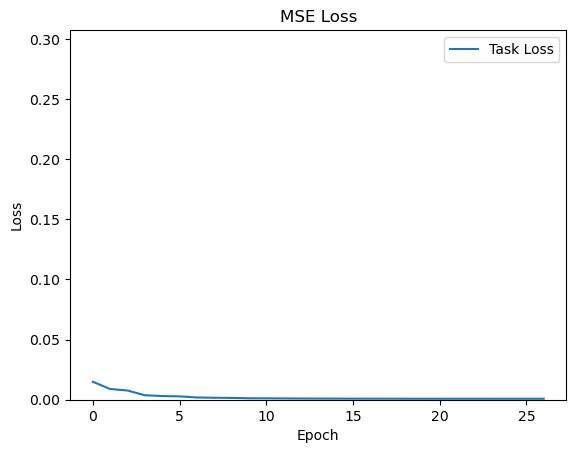

In [7]:
# lr=0.0002,if_low=False,act_decay=0.0,weight_decay=0.01,act_decay_to_one=False,h_bias=False,input_bias=True,rest_bias=True,irnn=True,activation=True,clip_grad=True,optimizer="Sophia"

lr = config.learning_rate
input_size = 2
hidden_size = config.hidden_size


model = CfC_NCP(input_size,hidden_size,if_low=config.low,lr=lr).to(device)
if config.if_scheduler:
    model.activate_scheduler(step_size=config.scheduler_step,gamma=config.scheduler_gamma)
model_compiled = torch.compile(model)

train = True
if train:
    _ = model_compiled.train_gradual_manual(input_data)
    model.plot_losses(average=30)
else:
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load("../trained models/CfC_NCP_LSTM_Low_20o2mrse.pt",map_location=device))
    model.eval()

In [8]:
for i in range(len(model.task_losses)):
    wandb.log({"Task_loss": model.task_losses[i], "Total_loss": model.total_losses[i]})

In [9]:
model_string = str(config.architecture) + "_" + str(run.id)
model_path = "../trained models/" + model_string  + ".pt"
torch.save(model.state_dict(), model_path)

In [10]:
model_art = wandb.Artifact(model_string, type='model')
model_art.add_file(model_path)

wandb.log_artifact(model_art)

<Artifact CfC_NCP_LSTM_Low_g8de1ucc>

## Activity/hidden state norms per tstep

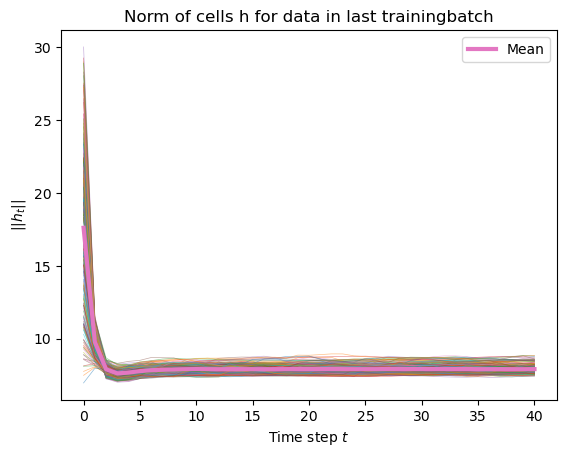

Mean norm:  8.165636


In [11]:
htss = model.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
mean_norms = plot_norm(htss,avg_only=False)

for norms in mean_norms:
    wandb.log({'mean_norm_per_tstep': norms})

## Tuning curves

In [12]:
t_test = 40
test_batch_size = 5000
test_generator = datagen2D_OU(circular=False)
data, labels = test_generator(test_batch_size,t_test)

In [13]:
activity, bin_edges_x, bin_edges_y = tuning_curve_2D_fullmodel(model,bins=50, in_activity=(data, labels),start=data[:,0,:])

100%|██████████| 256/256 [00:05<00:00, 48.20it/s]


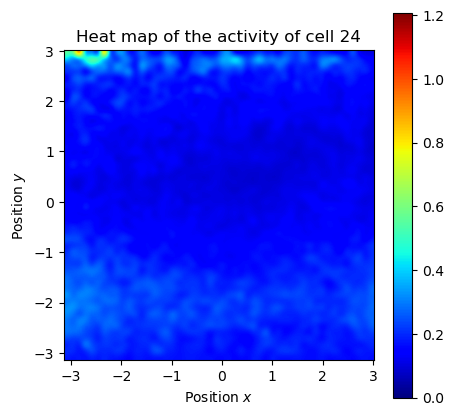

100%|██████████| 256/256 [00:00<00:00, 1381.29it/s]


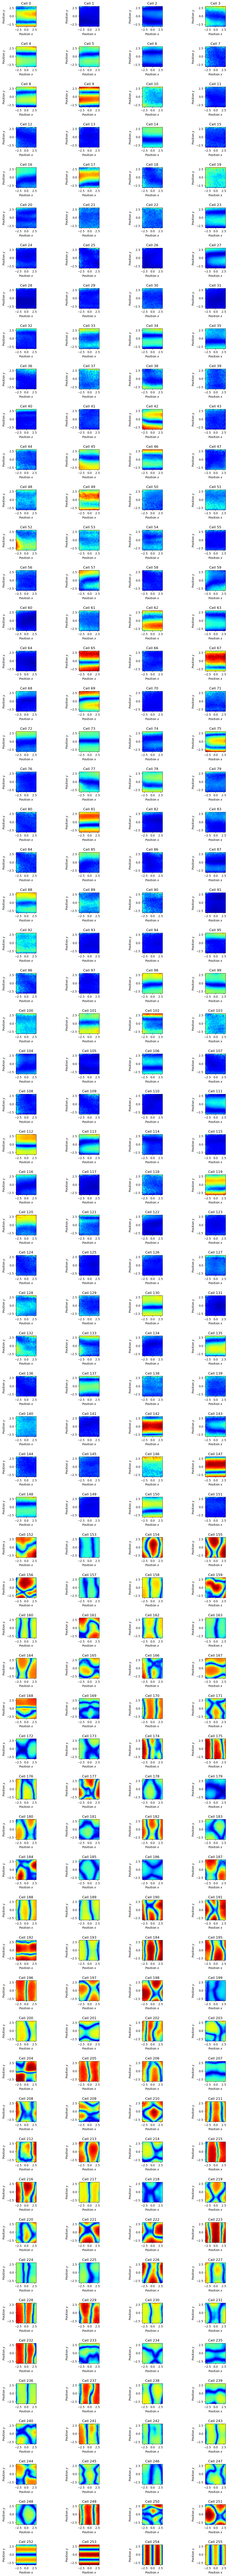

In [14]:
plot_2D_tuning_curve_2(activity,bin_edges_x, bin_edges_y,k_test=24,plot_head_frac=1,scale_to_one=False,more_plots=True)

In [15]:

# cells = [252,254,249,228,250]
cells = range(len(activity))
for cell in cells:
    normalized = (activity[cell] - np.min(activity[cell])) / (np.max(activity[cell]) - np.min(activity[cell]))
    images = wandb.Image(normalized, caption="Tuning Curves")
    wandb.log({"tuning_curves": images})

## Low-D Representation of activity

In [19]:
activity_flat = activity.reshape(activity.shape[0],-1)
embedding, reducer = lowD_reduce(activity_flat,if_pca=False,n_components=3,plot=True,n_neighbors=100)

(2500, 3)


In [20]:
wandb.log({"Activity Representation": wandb.Object3D(embedding)})

In [21]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
